<a href="https://colab.research.google.com/github/alif-munim/computer-vision/blob/main/yolov5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
# https://blog.paperspace.com/how-to-implement-a-yolo-object-detector-in-pytorch/
# https://github.com/ayooshkathuria/YOLO_v3_tutorial_from_scratch
# https://www.kdnuggets.com/2022/12/yolov5-pytorch-tutorial.html
# https://www.kaggle.com/general/74235

In [12]:
! pip install -q kaggle

In [13]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

In [17]:
! kaggle datasets download -d awsaf49/vinbigdata-512-image-dataset

100% 2.29G/2.30G [00:15<00:00, 206MB/s]
100% 2.30G/2.30G [00:16<00:00, 154MB/s]


In [ ]:
! unzip /content/vinbigdata-512-image-dataset.zip

In [22]:
import pandas as pd
import os
import numpy as np
import shutil
import ast
from sklearn import model_selection
from tqdm import tqdm

In [ ]:
! pip install wandb

In [26]:
import wandb
from sklearn.model_selection import GroupKFold
from IPython.display import Image, clear_output  # to display images
from os import listdir
from os.path import isfile
from glob import glob
import yaml

In [27]:
TRAIN_LABELS_PATH = './vinbigdata/labels/train'
VAL_LABELS_PATH = './vinbigdata/labels/val'
TRAIN_IMAGES_PATH = './vinbigdata/images/train' #12000
VAL_IMAGES_PATH = './vinbigdata/images/val' #3000
External_DIR = '../input/vinbigdata-512-image-dataset/vinbigdata/train' # 15000
os.makedirs(TRAIN_LABELS_PATH, exist_ok = True)
os.makedirs(VAL_LABELS_PATH, exist_ok = True)
os.makedirs(TRAIN_IMAGES_PATH, exist_ok = True)
os.makedirs(VAL_IMAGES_PATH, exist_ok = True)
size = 51

In [29]:
df = pd.read_csv('vinbigdata/train.csv')
df.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN,2332,2580
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN,2954,3159
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0,2080,2336
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0,2304,2880
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN,2540,3072


In [36]:
val_df = pd.read_csv('vinbigdata/test.csv')
val_df.head()

,image_id,width,height
0,83caa8a85e03606cf57e49147d7ac569,2304,2880
1,7550347fa2bb96c2354a3716dfa3a69c,2538,3095
2,74b23792db329cff5843e36efb8aa65a,2788,3120
3,94568a546be103177cb582d3e91cd2d8,1994,2430
4,6da36354fc904b63bc03eb3884e0c35c,2056,2376


In [30]:
df['x_min'] = df.apply(lambda row: (row.x_min)/row.width, axis = 1)*float(size)
df['y_min'] = df.apply(lambda row: (row.y_min)/row.height, axis = 1)*float(size)
df['x_max'] = df.apply(lambda row: (row.x_max)/row.width, axis =1)*float(size)
df['y_max'] = df.apply(lambda row: (row.y_max)/row.height, axis =1)*float(size)

df['x_mid'] = df.apply(lambda row: (row.x_max+row.x_min)/2, axis =1)
df['y_mid'] = df.apply(lambda row: (row.y_max+row.y_min)/2, axis =1)

df['w'] = df.apply(lambda row: (row.x_max-row.x_min), axis =1)
df['h'] = df.apply(lambda row: (row.y_max-row.y_min), axis =1)

df['x_mid'] /= float(size)
df['y_mid'] /= float(size)

df['w'] /= float(size)
df['h'] /= float(size)

In [45]:
train_df = df.iloc[1000:,:]
val_df = df.iloc[:1000,:]

In [42]:
def preproccess_data(df, labels_path, images_path):
    for column, row in tqdm(df.iterrows(), total=len(df)):
        attributes = row[
            ["class_id", "x_mid", "y_mid", "w", "h"]
        ].values
        attributes = np.array(attributes)
        np.savetxt(
            os.path.join(labels_path, f"{row['image_id']}.txt"),
            [attributes],
            fmt=["%d", "%f", "%f", "%f", "%f"],
        )
        shutil.copy(
            os.path.join(
                "vinbigdata/train",
                f"{row['image_id']}.png",
            ),
            images_path,
        )

In [46]:
preproccess_data(train_df, TRAIN_LABELS_PATH, TRAIN_IMAGES_PATH)

100%|██████████| 66914/66914 [01:42<00:00, 650.33it/s]


In [47]:
preproccess_data(val_df, VAL_LABELS_PATH, VAL_IMAGES_PATH)

100%|██████████| 1000/1000 [00:01<00:00, 840.09it/s]


In [39]:
classes = [ 'Aortic enlargement',
            'Atelectasis',
            'Calcification',
            'Cardiomegaly',
            'Consolidation',
            'ILD',
            'Infiltration',
            'Lung Opacity',
            'Nodule/Mass',
            'Other lesion',
            'Pleural effusion',
            'Pleural thickening',
            'Pneumothorax',
            'Pulmonary fibrosis']

data = dict(
    train =  '../vinbigdata/images/train',
    val   =  '../vinbigdata/images/val',
    nc    = 14,
    names = classes
    )

with open('./yolov5/vinbigdata.yaml', 'w') as outfile:
    yaml.dump(data, outfile, default_flow_style=False)

f = open('./yolov5/vinbigdata.yaml', 'r')
print('\nyaml:')
print(f.read())


yaml:
names:
- Aortic enlargement
- Atelectasis
- Calcification
- Cardiomegaly
- Consolidation
- ILD
- Infiltration
- Lung Opacity
- Nodule/Mass
- Other lesion
- Pleural effusion
- Pleural thickening
- Pneumothorax
- Pulmonary fibrosis
nc: 14
train: ../vinbigdata/images/train
val: ../vinbigdata/images/val



In [48]:
wandb.login()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [49]:
! export WANDB_NOTEBOOK_NAME=yolov5.ipynb

In [38]:
! git clone https://github.com/ultralytics/yolov5.git

Cloning into 'yolov5'...
remote: Enumerating objects: 15105, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 15105 (delta 28), reused 27 (delta 10), pack-reused 15045
Receiving objects: 100% (15105/15105), 14.12 MiB | 29.82 MiB/s, done.
Resolving deltas: 100% (10345/10345), done.


In [51]:
%cd ./yolov5
!pip install -U -r requirements.txt
!pip install pycocotools>=2.0 seaborn>=0.11.0 pandas thop
clear_output()

In [ ]:
!python train.py --img 512 --batch 16 --epochs 5 --data ./vinbigdata.yaml --cfg models/yolov5x.yaml --weights yolov5x.pt --cache --name vin

In [63]:
test_dir = (
    f"/content/vinbigdata/test"
)
weights_dir = "./runs/train/vin2/weights/best.pt"
os.listdir("./runs/train/vin2/weights")

['best.pt', 'last.pt']

In [ ]:
!python detect.py --weights $weights_dir\
--img 512\
--conf 0.15\
--iou 0.4\
--source $test_dir\
--save-txt --save-conf --exist-ok

In [2]:
fname = "17520d7b23b5a393d697ecf139b736fc"

In [78]:
with open(f'/content/yolov5/runs/detect/exp/labels/{fname}.txt') as file:
    print(file.readlines())

['3 0.567383 0.561523 0.396484 0.119141 0.187349\n']


In [ ]:
! pip install matplotlib==3.1.1

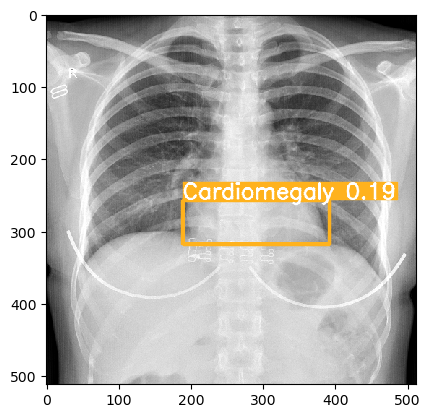

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as img

image = img.imread(f'/content/yolov5/runs/detect/exp/{fname}.png')
plt.imshow(image)
plt.show()